# Cumulative Distribution Functions

This notebook is for Chapter 3 (Cumulative Distribution Functions) of [Think Stats - Probability and Statistics for Programmers](http://greenteapress.com/thinkstats/) by Allen B Downey.

Objective is to understand CDFs as an alternative representation of distributions with many members, relation between percentiles (and other rank based metrics such as median and IQR) and CDFs, using CDFs for resampling, etc.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Class Size Paradox

Given a probability distribution, the mean of a distribution calculated from its PMF is lower than if we were to calculate the mean by taking a sample from it. This happens because the larger classes tend to get oversampled.

Text(0.5, 0, 'class size')

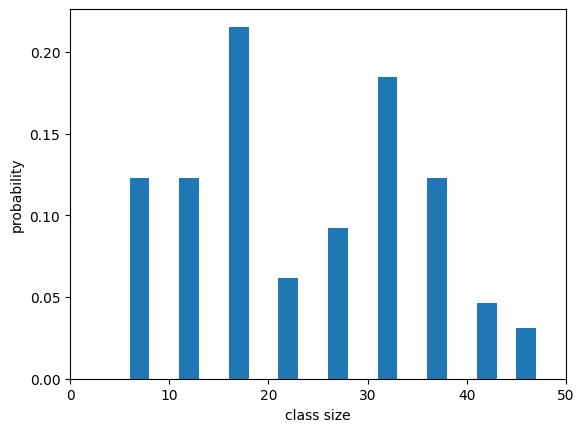

In [14]:
class_size_dist = {
    7: 8,
    12: 8,
    17: 14,
    22: 4,
    27: 6,
    32: 12,
    37: 8,
    42: 3,
    47: 2
}
class_sizes = []
for k in class_size_dist.keys():
    num_k = class_size_dist[k]
    for i in range(num_k):
        class_sizes.append(k)
pmf_class_sizes = np.histogram(np.array(class_sizes), bins=40, range=(7,47), density=True)
plt.bar(pmf_class_sizes[1][:-1], pmf_class_sizes[0], width=2)
plt.xlim([0, 50])
plt.ylabel("probability")
plt.xlabel("class size")

In [31]:
def pmf_mean(pmf):
    ps = pmf[0]
    xs = pmf[1][:-1]
    return np.dot(ps, xs)

dean_mean = pmf_mean(pmf_class_sizes)
print("Avg class size according to the Dean: %.3f" % (dean_mean))

Avg class size according to the Dean: 23.662


In [32]:
# extract and shuffle population
actual_pop = []
for key in class_size_dist.keys():
    for i in range(class_size_dist[key]):
        actual_pop.append(key)
pop = np.array(actual_pop)
np.random.shuffle(pop)

# sample from this population for 1/10-th the size
polled_sample = []
pop_size = pop.shape[0]
sample_size =  int(pop_size * 0.1)
for i in range(sample_size):
    dice = np.random.randint(pop_size)
    polled_sample.append(pop[dice])
polled_mean = sum(polled_sample) / len(polled_sample)

print("Avg class size according to polling: %d" % polled_mean)

Avg class size according to polling: 19


## Birth Weights

PMFs work well if the number of values is small, but as the number increases, the probability associated with each value gets smaller and smaller and the effect of random noise increases.

In [33]:
pregnancies = pd.read_fwf("2002FemPreg.dat", 
                         names=["caseid", "nbrnaliv", "babysex", "birthwgt_lb",
                               "birthwgt_oz", "prglength", "outcome", "birthord",
                               "agepreg", "finalwgt"],
                         colspecs=[(0, 12), (21, 22), (55, 56), (57, 58), (58, 60),
                                (274, 276), (276, 277), (278, 279), (283, 285), (422, 439)])
pregnancies.head()

,caseid,nbrnaliv,babysex,birthwgt_lb,birthwgt_oz,prglength,outcome,birthord,agepreg,finalwgt
0,1,1.0,1.0,8.0,13.0,39,1,1.0,33.0,6448.271112
1,1,1.0,2.0,7.0,14.0,39,1,2.0,39.0,6448.271112
2,2,3.0,1.0,9.0,2.0,39,1,1.0,14.0,12999.542264
3,2,1.0,2.0,7.0,0.0,39,1,2.0,17.0,12999.542264
4,2,1.0,2.0,6.0,3.0,39,1,3.0,18.0,12999.542264


C:\Users\diptiwar\AppData\Local\Temp\ipykernel_19672\3191878375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_babies_df["totwgt"] = first_babies_df["birthwgt_lb"] * 16 + \
C:\Users\diptiwar\AppData\Local\Temp\ipykernel_19672\3191878375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_babies_df["totwgt"] = other_babies_df["birthwgt_lb"] * 16 + \


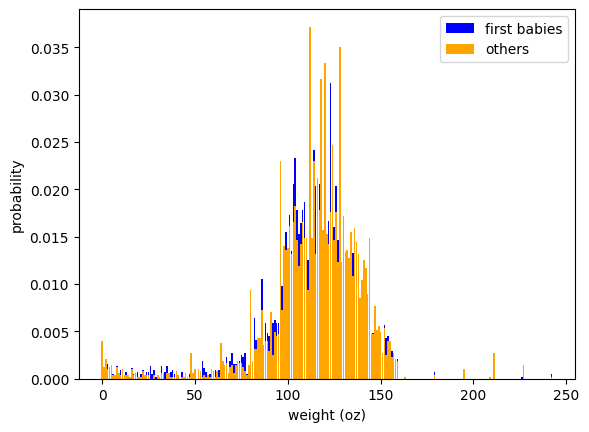

In [34]:
live_births = pregnancies[pregnancies["outcome"] == 1]

first_babies_df = live_births[live_births["birthord"] == 1]
first_babies_df["totwgt"] = first_babies_df["birthwgt_lb"] * 16 + \
    first_babies_df["birthwgt_oz"]
other_babies_df = live_births[live_births["birthord"] != 1]
other_babies_df["totwgt"] = other_babies_df["birthwgt_lb"] * 16 + \
    other_babies_df["birthwgt_oz"]

first_babies = np.array(first_babies_df["totwgt"].dropna())
other_babies = np.array(other_babies_df["totwgt"].dropna())

range_lb = int(min([np.min(first_babies), np.min(other_babies)]))
range_ub = int(max([np.max(first_babies), np.max(other_babies)]))
nbr_bins = range_ub - range_lb

pmf_first_babies = np.histogram(np.array(first_babies), 
                                bins=nbr_bins, range=(range_lb, range_ub), density=True)
pmf_other_babies = np.histogram(np.array(other_babies), 
                                bins=nbr_bins, range=(range_lb, range_ub), density=True)

width = 0.001
plt.bar(np.arange(range_lb, range_ub), pmf_first_babies[0], color="blue", label="first babies")
plt.bar(np.arange(range_lb, range_ub) + width, pmf_other_babies[0], 
         color="orange", label="others")
plt.xlabel("weight (oz)")
plt.ylabel("probability")
plt.legend(loc="best")

## Percentiles

In [35]:
def percentile_rank(xs, score):
    count = 0
    for x in xs:
        if x < score:
            count += 1
    return 100.0 * count / len(xs)

def percentile(xs, rank):
    sxs = sorted(xs)
    for x in sxs:
        if percentile_rank(sxs, x) >= rank:
            return x

scores = np.array([55, 66, 77, 88, 99])
print("Percentile rank for 88: %d" % (percentile_rank(scores, 88)))
print("Percentile for rank 60: %d" % (percentile(scores, 60)))

Percentile rank for 88: 60
Percentile for rank 60: 88


## CDFs

### Representing CDFs


Text(0, 0.5, 'CDF(x)')

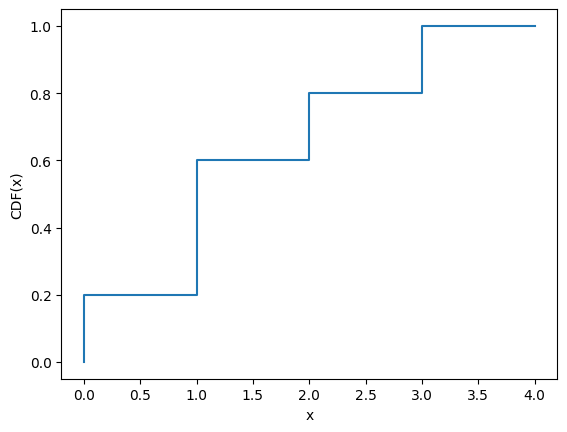

In [23]:
sample = [1, 2, 2, 3, 5]
hist = np.histogram(sample, bins=5, range=(0, 5), density=True)
plt.step(hist[1][:-1], np.cumsum(hist[0]))
plt.xlabel("x")
plt.ylabel("CDF(x)")

### CDF for the survey data

Based on the visualization below, it appears that there is almost no variation of birth weights between first born children and other children.

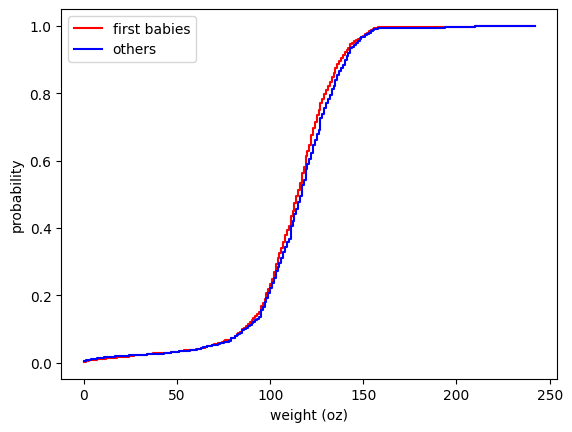

In [24]:
def cdf(pmf):
    xs = pmf[1][:-1]
    ps = np.cumsum(pmf[0])
    return np.vstack((xs, ps)).T

cdf_first_babies = cdf(pmf_first_babies)
cdf_other_babies = cdf(pmf_other_babies)
plt.step(cdf_first_babies[:, 0], cdf_first_babies[:, 1], color="r", label="first babies")
plt.step(cdf_other_babies[:, 0], cdf_other_babies[:, 1], color="b", label="others")
plt.xlabel("weight (oz)")
plt.ylabel("probability")
plt.legend(loc="best")

A first born weighing 7 lb 9oz has a probability of 0.63 and a percentile rank of 63. Conversely, a first born in the 75 percentile rank has 

In [26]:
xs = cdf_first_babies[:, 0]
ps = cdf_first_babies[:, 1]

# given the weight find the percentile
birth_weight = (7 * 16) + 9
for i in range(xs.shape[0]):
    if xs[i] >= birth_weight:
        break
pc_rank = ps[i] * 100
print("Percentile rank of first baby 7 lb 9 oz: %.3f" % (pc_rank))

# given the percentile find the weight
percentile = 75
for i in range(ps.shape[0]):
    if ps[i] > 0.01 * percentile:
        break
weight = xs[i]
print("Weight of first born in the 75th percentile: %.3f oz" % (weight))

Percentile rank of first baby 7 lb 9 oz: 62.862
Weight of first born in the 75th percentile: 128.000 oz


## Conditional Distributions

Distribution of a subset of data which is selected according to a condition.

Overall rank in race: 97 out of 1633, what is percentile rank?

Rank in division: 26 out of 256, what is percentile rank in division?

In [27]:
overall_percentile_rank = 97.0 * 100 / 1633
division_percentile_rank = 26.0 * 100 / 256
print("overall percentile rank: %.3f, percentile rank in division: %.3f" % 
      (overall_percentile_rank, division_percentile_rank))

overall percentile rank: 5.940, percentile rank in division: 10.156


## Random Numbers

CDFs are useful for generating random numbers with a given distribution. We will use the first born birth weights to generate a sample from it.

The process of generating a sample based on another sample is called resampling. Resampling can be with replacement (random.random or random.choice) and without replacement (random.sample).

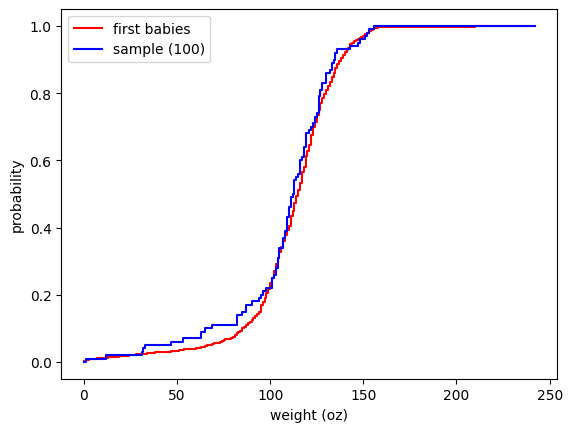

In [28]:
sample_size = 100
samples = []
for i in range(sample_size):
    prob = np.random.random()
    for j in range(ps.shape[0]):
        if ps[j] > prob:
            break
    samples.append(xs[j])

# create a CDF for the new sample
pmf_sample = np.histogram(np.array(samples), 
                          bins=nbr_bins, range=(range_lb, range_ub), density=True)
cdf_sample = cdf(pmf_sample)

# plot CDF for original and sample
plt.step(cdf_first_babies[:, 0], cdf_first_babies[:, 1], color="r", label="first babies")
plt.step(cdf_sample[:, 0], cdf_sample[:, 1], color="b", label="sample (100)")
plt.xlabel("weight (oz)")
plt.ylabel("probability")
plt.legend(loc="best")

Generate 1000 numbers using random.random and plot their PMF and CDF. The CDF indicates that its a uniform distribution because cumulative probability increases almost linearly.

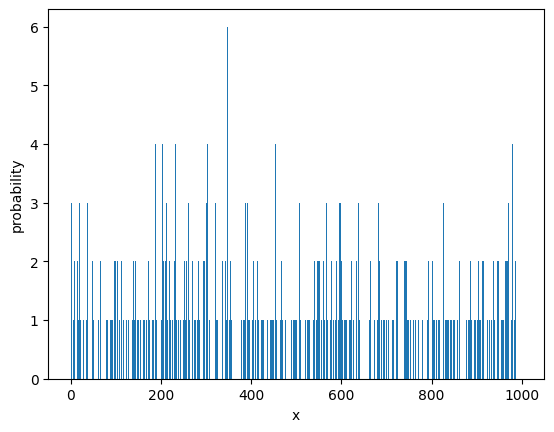

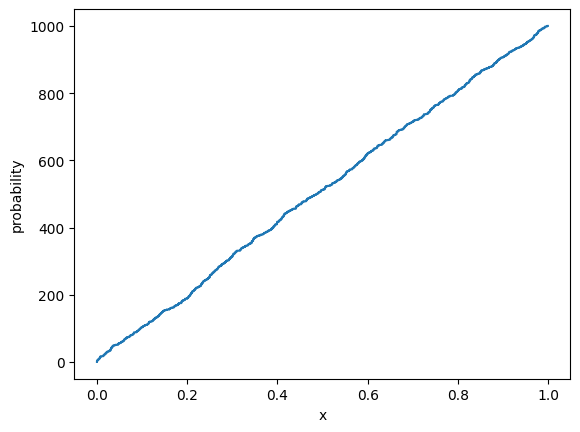

In [29]:
random_pop = np.random.random(1000)
pmf_random = np.histogram(random_pop, bins=1000, range=(0, 1), density=True)

# plot PMF
plt.bar(range(1000), pmf_random[0])
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

# plot CDF
cdf_random = cdf(pmf_random)
plt.step(cdf_random[:, 0], cdf_random[:, 1])
plt.xlabel("x")
plt.ylabel("probability")
plt.show()

## Summary Statistics Revisited

We find the median and IQR using the CDF for the firstborn birth weights.

In [30]:
xs = cdf_first_babies[:, 0]
ps = cdf_first_babies[:, 1]

# median
for i in range(ps.shape[0]):
    if ps[i] >= 0.5:
        break
print("median = %.3f" % (xs[i]))

# IQR
for i in range(ps.shape[0]):
    if ps[i] >= 0.25:
        break
q1 = xs[i]
for i in range(ps.shape[0]):
    if ps[i] >= 0.75:
        break
q3 = xs[i]
iqr = q3 - q1
print("Q1 = %.3f, Q3 = %.3f, IQR = %.3f" % (q1, q3, iqr))

median = 116.000
Q1 = 103.000, Q3 = 128.000, IQR = 25.000
